Inspired in: https://playground.tensorflow.org/

In [472]:
using Revise
using PyPlot, OCDNN, Printf, Random

In [514]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [838]:
f(x) = 2*x + sin(2x) + 3

f (generic function with 1 method)

In [880]:
Random.seed!(123)
xs = 0:0.02:5
ys = f.(xs) + randn(length(xs));

In [881]:
N = length(xs)

251

In [882]:
dataset = reshape(collect(xs),length(xs),1), ys;

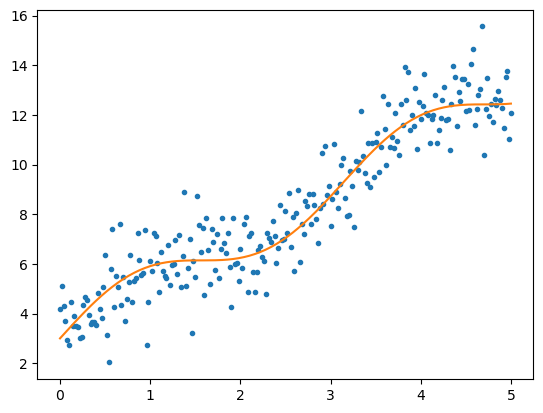

In [883]:
plot(xs, ys, ".")
plot(xs, f.(xs) );

In [884]:
nlayers = 2
channels = 5 # number of neurons per layer
niter = 50_000
τ=0.01;
τ_max=0.2;
stepsize = 0.1;

In [885]:
A_eu = reshape([0],(1,1));
w_eu = [1];
A_ie = [0 0; 1 0];
w_ie = [0.5 ;0.5];
A_kutta4 = [0 0 0 0;0.5 0 0 0;0 0.5 0 0;0 0 1 0];
w_kutta4 = 1/6*[1;2;2;1];
A_kutta3 = [0 0 0;1/2 0 0;-1 2 0];
w_kutta3 = [1/6;2/3;1/6];

In [886]:
rk4 = OCDNN.ExplicitRungeKutta(A_kutta4,w_kutta4,"RK4");
rk3 = OCDNN.ExplicitRungeKutta(A_kutta3,w_kutta3,"RK3");
rk2 = OCDNN.ExplicitRungeKutta(A_ie,w_ie,"RK2");
euler = OCDNN.ExplicitRungeKutta(A_eu,w_eu,"Euler");
rks = [euler,rk2,rk3,rk4];
names = [rk.name for rk in rks];

In [887]:
eta = x -> exp(x)/(exp(x)+1)
eta = x -> x

#293 (generic function with 1 method)

In [888]:
problem = OCDNN.Problem(tanh, eta, ys);

In [889]:
function cb(iter, rkmethod, nlayers, α, log, Ctrls)
    period = 10_000
    if rem(iter,period) == 0 || iter == 1
        @printf("\nMethod=%s, nlayers=%d\n",rkmethod.name,nlayers)
        @printf("Iteration no: %d\n",iter)
        @printf("Value of alpha: %7.4f\n",α);
        @printf("Residual: %8.4f\n",log.loss[end])
        @printf("Norm Grad: %8.4e\n",log.grad_norm[end]);
        if iter > 1
            @printf("Time: %8.4f\n",sum(log.time[end-period+1:end]));
        end
    end
end

cb (generic function with 1 method)

In [890]:
xs, feat = dataset;

In [891]:
all_results = [train_ode_dnn(dataset, nlayers, channels, rk, niter, τ, τ_max, stepsize, problem, cb) for rk in rks];


Method=Euler, nlayers=2
Iteration no: 1
Value of alpha:  0.0003
Residual: 2422.4418
Norm Grad: 9.8563e+03

Method=Euler, nlayers=2
Iteration no: 10000
Value of alpha:  0.0013
Residual: 140.6501
Norm Grad: 1.1741e+00
Time:  22.8136

Method=Euler, nlayers=2
Iteration no: 20000
Value of alpha:  0.0006
Residual: 133.1888
Norm Grad: 9.9629e-01
Time:  23.4153

Method=Euler, nlayers=2
Iteration no: 30000
Value of alpha:  0.0006
Residual: 131.1266
Norm Grad: 6.4773e-01
Time:  30.8257

Method=Euler, nlayers=2
Iteration no: 40000
Value of alpha:  0.0013
Residual: 130.6644
Norm Grad: 1.6031e-01
Time:  31.6523

Method=Euler, nlayers=2
Iteration no: 50000
Value of alpha:  0.0006
Residual: 130.5598
Norm Grad: 1.1068e-01
Time:  32.3357

Method=RK2, nlayers=2
Iteration no: 1
Value of alpha:  0.0003
Residual: 1015.5361
Norm Grad: 9.0567e+03

Method=RK2, nlayers=2
Iteration no: 10000
Value of alpha:  0.0025
Residual: 134.9613
Norm Grad: 9.2647e-01
Time:  69.5231

Method=RK2, nlayers=2
Iteration no: 200

In [894]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(niter)*"_iter_"*string(channels)*"_channels"
outputdir = "Non_Linear_Regression\\"*final_string
if !isdir(outputdir)
    mkdir(outputdir)
end

"Non_Linear_Regression\\2_layers_251_points_50000_iter_10_channels"

In [895]:
all_Ctrls,all_logs = first.(all_results),last.(all_results);

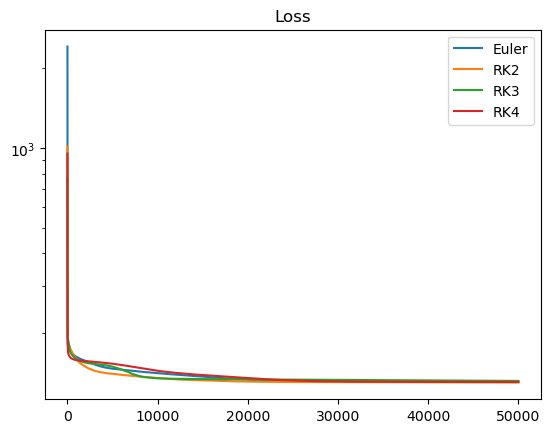

PyObject <matplotlib.legend.Legend object at 0x00000000072FBC88>

In [896]:
fig, axs = PyPlot.subplots()
axs.set_title("Loss")
for i in 1:4
    axs.semilogy(all_logs[i].loss, label = names[i])
end
legend()

In [897]:
in_dir(outputdir) do
    fig.savefig("loss_rks_"*final_string*".pdf")
end

In [898]:
all_times = [sum(all_logs[i].time) for i in 1:4];

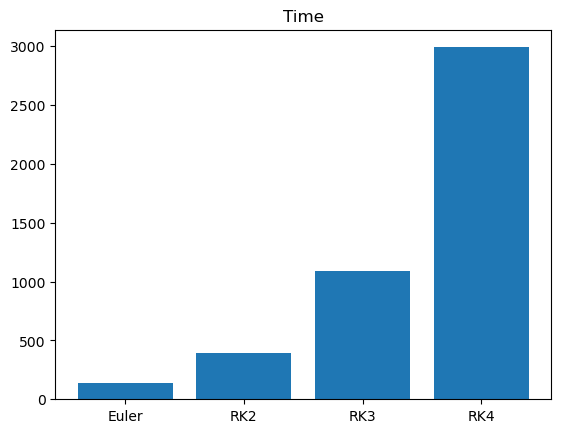

In [899]:
fig, ax = PyPlot.subplots()
ax.set_title("Time")
ax.bar(1:4,height=all_times)
ax.set_xticks(1:4)
ax.set_xticklabels(names);

In [900]:
in_dir(outputdir) do
    fig.savefig("time_rks_"*final_string*".pdf")
end

In [901]:
all_Ctrls_test = deepcopy.(all_Ctrls);

In [902]:
xs1 = collect(0:0.01:5);

In [903]:
Y0_test = [[x] for x in xs1];

In [904]:
for i in 1:4
    all_Ctrls_test[i].Y0 = hcat(Y0_test...)';
end

In [905]:
classifieds = [[] for i in 1:4]
for i in 1:4
    classifieds[i] = OCDNN.RKforwardstepper(all_Ctrls_test[i],rks[i],problem).Classifier;
end

In [906]:
# Linear Regression
β1 = sum((xs.-1/length(xs)*sum(xs)).*ys)/sum((xs.-1/length(xs)*sum(xs)).^2)
β0 = 1/length(ys)*sum(ys).-β1.*1/length(xs)*sum(xs);

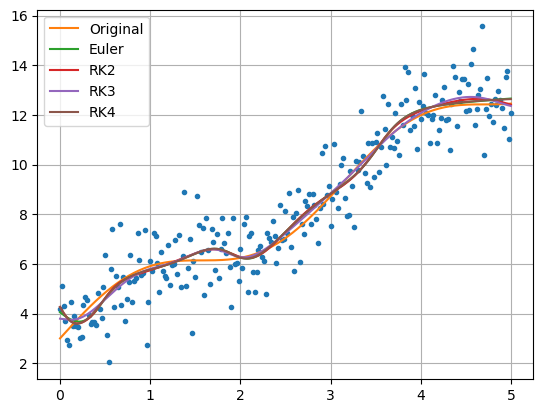

PyObject <matplotlib.legend.Legend object at 0x0000000064261B08>

In [909]:
fig, ax = PyPlot.subplots()
ax.plot(xs, ys, ".")
ax.plot(xs, f.(xs) , label="Original");
#ax.plot(xs, β1 .*xs .+ β0, label="Linear Reg");
for i in 1:4
    ax.plot(xs1, classifieds[i], label=names[i])
end
ax.grid()
ax.legend()

In [910]:
in_dir(outputdir) do
    fig.savefig("Linear_Reg_rks"*final_string*".pdf")
end